## Evaluate Model Against Real Hurricanes

In [2]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2024-09-16 17:10:53.406806: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 17:10:53.414952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 17:10:53.423480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 17:10:53.426000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 17:10:53.433201: I tensorflow/core/platform/cpu_feature_guar

### Prepare all required dataframes (depending on model features)

In [60]:
tf.debugging.set_log_device_placement(
    True
)

In [61]:
print(tf.config.get_visible_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Obtain Cyclone Data
df = pd.read_csv("../raw-data/hurricaneData.csv")

In [7]:
# EP hurricanes for eval purposes
SID_EP = []  # Using a set to store unique SIDs
for _, row in df.iterrows():  # Iterating through DataFrame rows
    if row["BASIN"] == "EP":  # Check if basin is "EP"
        if row["SID"] not in SID_EP:
            SID_EP.append(row["SID"])  # Add unique SID to the set

In [5]:
# Drop all attributes, expect Longitude, Latitude, Time and SID
simple_df = df.drop(['SEASON','NUMBER','BASIN','SUBBASIN','NAME','NATURE','WMO_WIND','WMO_PRES','WMO_AGENCY','TRACK_TYPE','DIST2LAND','LANDFALL','IFLAG'],axis=1)

In [6]:
# Drop all data points prior to year=1900
simple_df = simple_df.iloc[9461:]

In [7]:
# Convert ISO_TIME to datetime
simple_df['ISO_TIME'] = pd.to_datetime(simple_df['ISO_TIME'], format='%d/%m/%Y %H:%M')

In [8]:
# Remove all data points which are not in 3 hour increments 
simple_df = simple_df[simple_df['ISO_TIME'].dt.hour % 3 == 0]

In [9]:
# Convert longitudes and latitudes to x, y, z coordinates
def FeatureColumnsXYZ(dframe):
    dframe['x'] = np.cos(np.radians(dframe.LAT)) * np.cos(np.radians(dframe.LON))
    dframe['y'] = np.cos(np.radians(dframe.LAT)) * np.sin(np.radians(dframe.LON))
    dframe['z'] = np.sin(np.radians(dframe.LAT))

In [10]:
FeatureColumnsXYZ(simple_df)

We must now remove all hurricanes in the dataset with too few datapoints (<30)

In [11]:
SID_values = []
for value in simple_df['SID']:
    if value not in SID_values:
        SID_values.append(value)
grouped = simple_df.groupby('SID')

In [12]:
# remove all hurricanes with less than 15 data points approx ~200
SID_to_drop = []
for value in SID_values:
    if len(grouped.groups[value]) < 15:
        if value not in SID_to_drop:
            SID_to_drop.append(value)

In [13]:
def drop_rows_by_sid(df, sid_list):
    # Drop rows where the SID is in the sid_list
    df_filtered = df[~df['SID'].isin(sid_list)]
    
    return df_filtered
simple_df = drop_rows_by_sid(simple_df,SID_to_drop)

In [14]:
grouped = simple_df.groupby('SID')

In [15]:
countSID = []
for value in simple_df['SID']:
    if value not in countSID:
        countSID.append(value)

In [16]:
# Confirm number of removed hurricanes
print("original: " + str(len(SID_values)))
print("new: " + str(len(countSID))) 

original: 3911
new: 3649


## MSE Evaluation

We now have a dataframe with all the required hurricane data, and a list of all SID's. We can now start evaluation.

In [17]:
# Get all the points for a given SID
def get_points_for_sid(df, sid):
    # Filter the DataFrame for the given SID
    filtered_df = df[df['SID'] == sid]
    # Extract the x, y, and z columns and convert them to a 2D NumPy array
    points_array = filtered_df[['x', 'y', 'z']].to_numpy()
    return points_array

In [18]:
# Predict the path of a hurricane, based on an initial sequence and total steps
def predict_path(model, initial_sequence, steps):
    minSteps = min(16,steps) ## only predict up to next 48 hours
    path = []
    current_sequence = initial_sequence
    i = 1
    
    for _ in range(minSteps):
        # Predict the next point
        next_point = model.predict(np.expand_dims(current_sequence, axis=0),verbose=i)
        
        # Append the prediction to the path
        path.append(next_point[0])
        
        # Update the current sequence by appending the predicted point
        current_sequence = np.append(current_sequence[1:], next_point, axis=0)
        i = 0
    
    return np.array(path)

In [19]:
# predict the of path of hurricane, using predict_path function, based on window_size
def evaluateModel(model, actual_hurricane_path, window_size):
    predicted_paths = []
    predicted_paths.append(predict_path(model, actual_hurricane_path[0:window_size], steps=len(actual_hurricane_path)-window_size))
    return predicted_paths

In [20]:
# return list of MSE (actual vs. predicted path) for each hurricane in SID_list for given model
def totalMSE(model,window_size,SID_list,df):
    mse = []
    for sid in SID_list:
        actual_path = get_points_for_sid(df,sid)
        pred_path = evaluateModel(model,actual_path,window_size)
        mse.append(np.mean((pred_path - actual_path[window_size:len(pred_path)+window_size]) ** 2))
    return mse

In [21]:
# return average MSE
def averageMSE(mseList):
    n = len(mseList)
    total = 0
    for elem in mseList:
        total += elem
    return total/n

In [62]:
SID_list = countSID[3645:] # ["1945271N06160","1978252N17119", "1978279N14142"] # hurricanes to be tested against

In [23]:
SID_EP_list = SID_EP[360:]

NameError: name 'SID_EP' is not defined

In [24]:
# create a dictionary to save model and associated window_size
model_dict = dict()

In [57]:
model_names = ['single_variable_L2D2De2_WS5_E15',
               'single_variable_LGDe2_WS10_E10',
               'ibtracs_lstm_model_v1_10epoch_batch1024_LSTM64_LSTM64_DENSE3',
               'ibtracs_lstm_model_v4_10epoch_LSTM64_DENSE3',
               'ibtracs_lstm_model_v5_10epoch_batch1024_LSTM64_DENSE3',
               'single_variable_LDe2_WS10_E100_B64_steps_4',
               'single_variable_LDe2_WS10_E50_B64_steps_3',
               'single_variable_LGDe2_WS10_E10_steps_1',
               'single_variable_LGDe2_WS10_E30_steps_2',
              'single_variable_LSTM_Dropout_Dense_lr_0.0004_ws8',
              'pacific_lstm_model_v1_100epoch_batch1024_LSTM64_DENSE3',
              'pacific_lstm_model_v2_50epoch_batch1024_LSTM64_DENSE3']

In [26]:
model_0 = load_model("../models/" + model_names[0] + ".keras")

I0000 00:00:1726470717.027024    5706 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726470717.027086    5706 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726470717.027112    5706 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726470717.125280    5706 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726470717.125339    5706 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-16

In [27]:
model_1 = load_model("../models/" + model_names[1] + ".keras")

In [28]:
model_3 = load_model("../models/" + model_names[2] + ".keras")

In [29]:
model_7 = load_model("../models/" + model_names[3] + ".keras")

In [30]:
model_8 = load_model("../models/" + model_names[4] + ".keras")

In [31]:
model_9 = load_model("../models/" + model_names[5] + ".keras")

In [32]:
model_10 = load_model("../models/" + model_names[6] + ".keras")

In [33]:
model_11 = load_model("../models/" + model_names[7] + ".keras")

In [34]:
model_12 = load_model("../models/" + model_names[8] + ".keras")

In [35]:
model_13 = load_model("../models/" + model_names[9] + ".keras")

In [36]:
model_14 = load_model("../models/" + model_names[10] + ".keras")

In [37]:
model_15 = load_model("../models/" + model_names[11] + ".keras")

In [38]:
model_dict[model_0] = 5

In [41]:
model_dict[model_1] = 10

In [42]:
model_dict[model_3] = 5

In [43]:
model_dict[model_7] = 5

In [44]:
model_dict[model_8] = 5

In [45]:
model_dict[model_9] = 10

In [46]:
model_dict[model_10] = 10

In [47]:
model_dict[model_11] = 10

In [48]:
model_dict[model_12] = 10

In [49]:
model_dict[model_13] = 8

In [50]:
model_dict[model_14] = 5

In [51]:
model_dict[model_15] = 5

In [52]:
def evaluateAllModels(model_dict,sid_in,df):
    final_MSE_values = []
    for m,w in model_dict.items():
        mseList = totalMSE(m,w,sid_in,df)
        final_MSE_values.append(averageMSE(mseList))
    return final_MSE_values

In [63]:
final_MSE_values = evaluateAllModels(model_dict,SID_list,simple_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━

In [64]:
final_MSE_values

[0.04263612610596594,
 0.004082884231366774,
 0.00037702070109900377,
 0.0011225331389618262,
 0.0014872439098410643,
 0.0011668510286905389,
 0.0007786481898051991,
 0.003068451549989696,
 0.0010241500000496783,
 0.002157614291523519,
 0.007240525873358901,
 0.003450312781417504]

In [67]:
def plotMSE(MSE_values, model_names):
    # Create the plot
    plt.figure(figsize=(8, 5))
    plt.bar(model_names[2:], MSE_values[2:], color='blue')
    plt.xticks(rotation=90, fontsize=6)
    
    # Add title and labels
    plt.title('MSE vs. Model over 48 hour (16 step) Hurricane Paths')
    plt.xlabel('Model')
    plt.ylabel('Mean Squared Error (MSE)')
    
    # Display the plot
    plt.show()

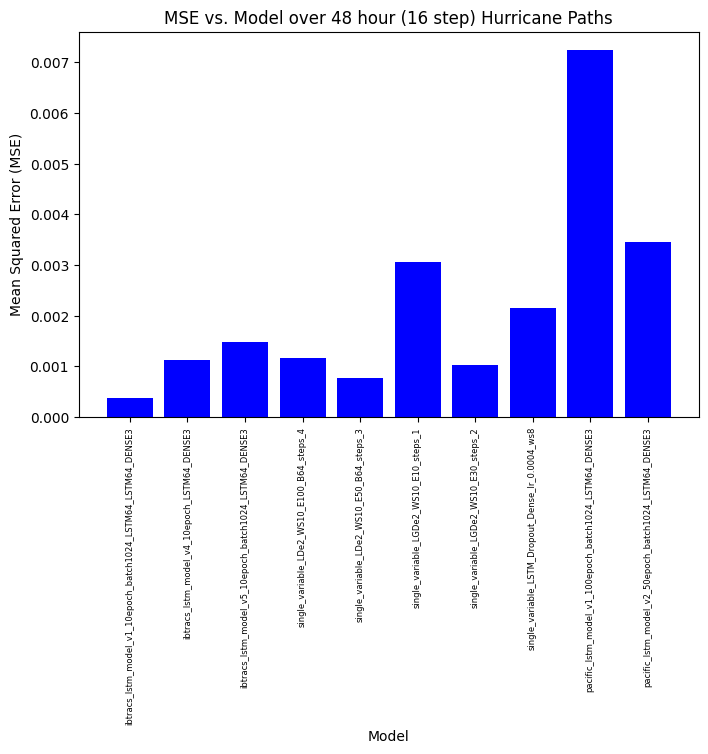

In [68]:
plotMSE(final_MSE_values,model_names)

## MSE-Point Model Evaluation 

In [70]:
# Only consider first n predicted steps
def point_mse(model, SID_list, window_size, n):
    mse_total = [0] * n
    for SID in SID_list:
        actual_path = get_points_for_sid(simple_df,SID)
        if (len(actual_path) < 28): 
            continue
        pred_path = evaluateModel(model, actual_path, window_size)
        for i in range(n):    
            mse_total[i] += np.mean((pred_path[0][i] - actual_path[window_size + i]) ** 2)
    mse_total[:] = [x / n for x in mse_total]
    return mse_total

In [71]:
def point_mse_all_models(n,SID_list):
    MSE_average_all_models = []
    for model in model_dict:
        MSE_average_all_models.append(point_mse(model,SID_list,model_dict[model],n))
    return MSE_average_all_models

In [72]:
MSE_average_all_models = point_mse_all_models(16,countSID[3580:3600])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [73]:
MSE_average_all_models

[[0.00055666776370039,
  0.001853809987425256,
  0.00436345483800029,
  0.0082613826240969,
  0.013324278687724154,
  0.018784948785801066,
  0.023829173032612075,
  0.027667442574130827,
  0.030221366940326306,
  0.031478336022545406,
  0.03182008995548157,
  0.031610368805955545,
  0.031376580202850585,
  0.031102384520490772,
  0.03087765685200327,
  0.030693491561004222],
 [5.45526718153409e-06,
  3.477347117609487e-05,
  0.00012343905914391506,
  0.0002971592852354993,
  0.000622928885411551,
  0.0011260334510656675,
  0.0018773229308870732,
  0.0029629970007365863,
  0.004389649684387268,
  0.0061417438412201125,
  0.00829442656745295,
  0.010779011762816914,
  0.01368116557921949,
  0.01694626229701698,
  0.020675207502609816,
  0.02489542573606289],
 [2.685135220547413e-05,
  5.0248876735130815e-05,
  9.299351915398079e-05,
  0.00015392018211198604,
  0.00022636920238810454,
  0.0003059999248437428,
  0.00037918716852793305,
  0.00046400187041004153,
  0.0005619435364956529,
  

In [74]:
def plot_MSE_eval(n):
    # Add title and labels
    plt.figure(figsize=(16,8))
    plt.title(f'Average MSE over {n*3} hour ({n} step) Predicted Hurricane Paths (Various Models)')
    plt.xlabel('Time (3 hour time-steps)')
    plt.ylabel('Average Mean Squared Error (MSE)')

    i = 0
    for model in model_dict:
        if (i<2):
            i+=1
            continue
        if (i>=10):
            break
        plt.plot(MSE_average_all_models[i][:n], label=model_names[i])
        # To confirm Models are being labelled correctly
        # print(model_names[i]) 
        # print(model.summary())
        i+=1

    plt.legend(loc='upper left')

    plt.show()

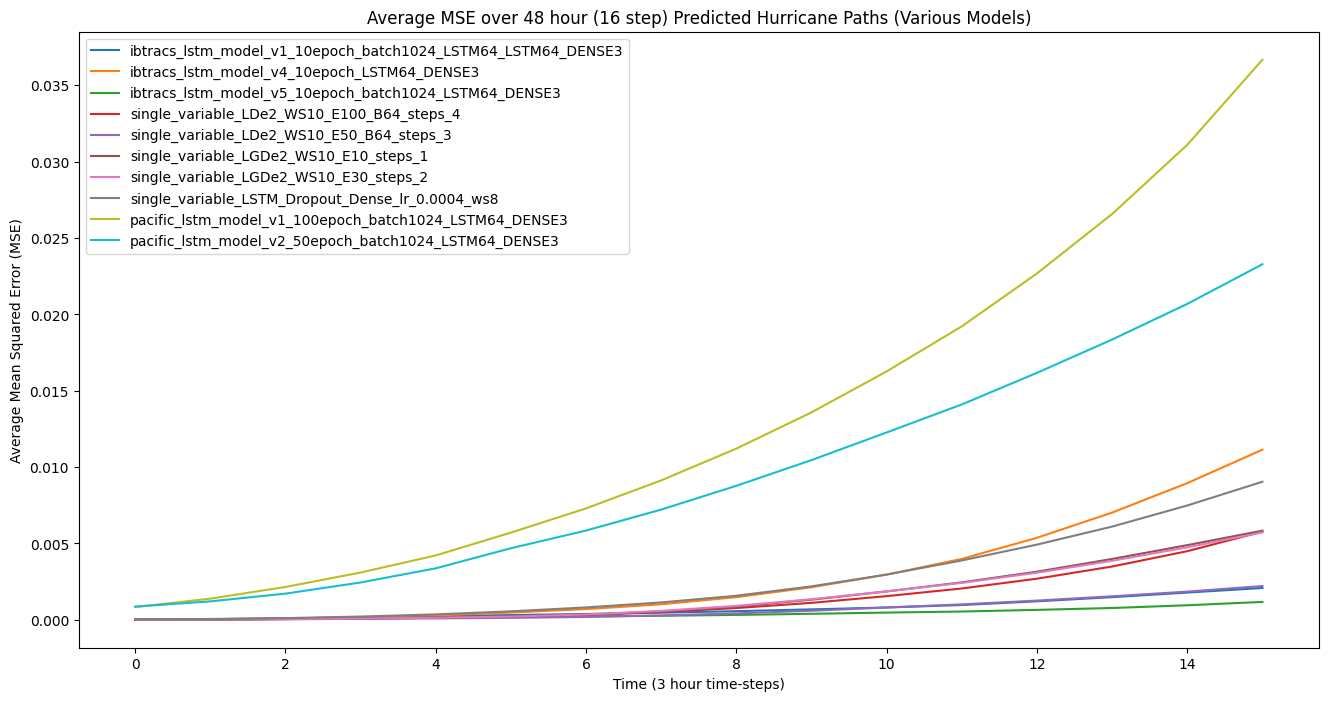

In [77]:
plot_MSE_eval(16)

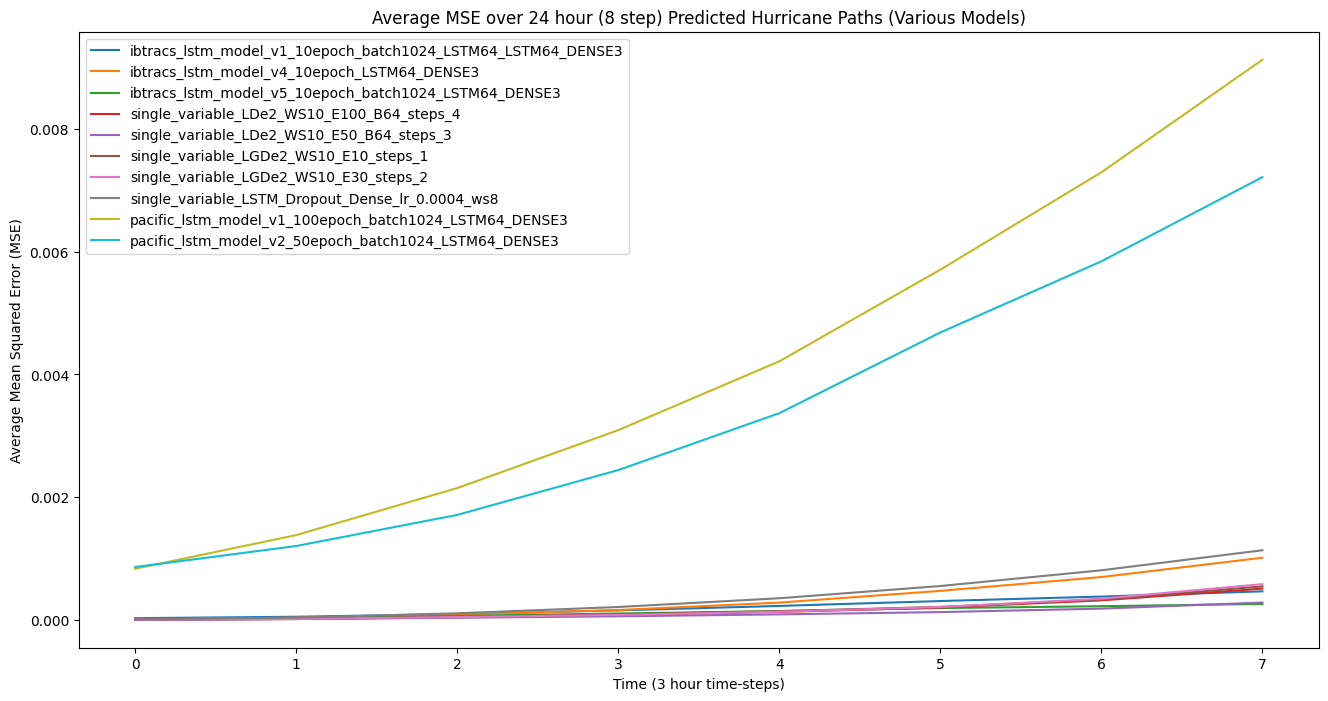

In [78]:
plot_MSE_eval(8)

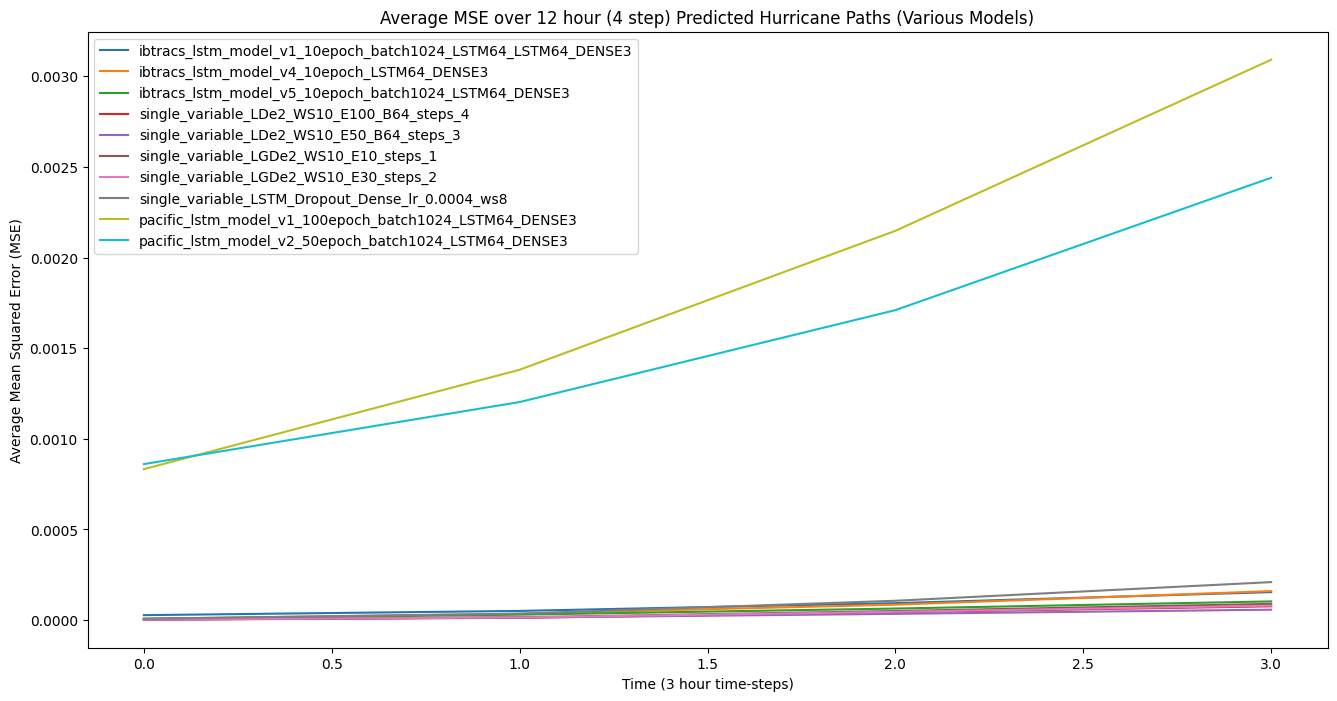

In [79]:
plot_MSE_eval(4)